In [1]:
# Article Reference: https://towardsdatascience.com/feature-detection-part-1-image-derivatives-gradients-and-sobel-operator/

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

!wget -O sudoku.png https://raw.githubusercontent.com/opencv/opencv/4.x/samples/data/sudoku.png

# Load the image and convert to grayscale scheme
# Intensity Formula (OpenCV) = 0.299*R + 0.587*G + 0.114*B
# Edge detection relies on changes in pixel intensity, not color.
sudoku_image_path = "sudoku.png"
if not os.path.exists(sudoku_image_path):
    print("Error: Image NOT found.")
else:
    sudoku_image = cv2.imread(sudoku_image_path)
    sudoku_image = cv2.cvtColor(sudoku_image, cv2.COLOR_BGR2GRAY)

# To-do: Implement Coin Example

--2025-12-31 14:55:04--  https://raw.githubusercontent.com/opencv/opencv/4.x/samples/data/sudoku.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250720 (245K) [image/png]
Saving to: ‘sudoku.png’

sudoku.png          100%[===================>] 244.84K  --.-KB/s    in 0.03s   

2025-12-31 14:55:05 (7.80 MB/s) - ‘sudoku.png’ saved [250720/250720]



Value range: (-496.00, 474.00)


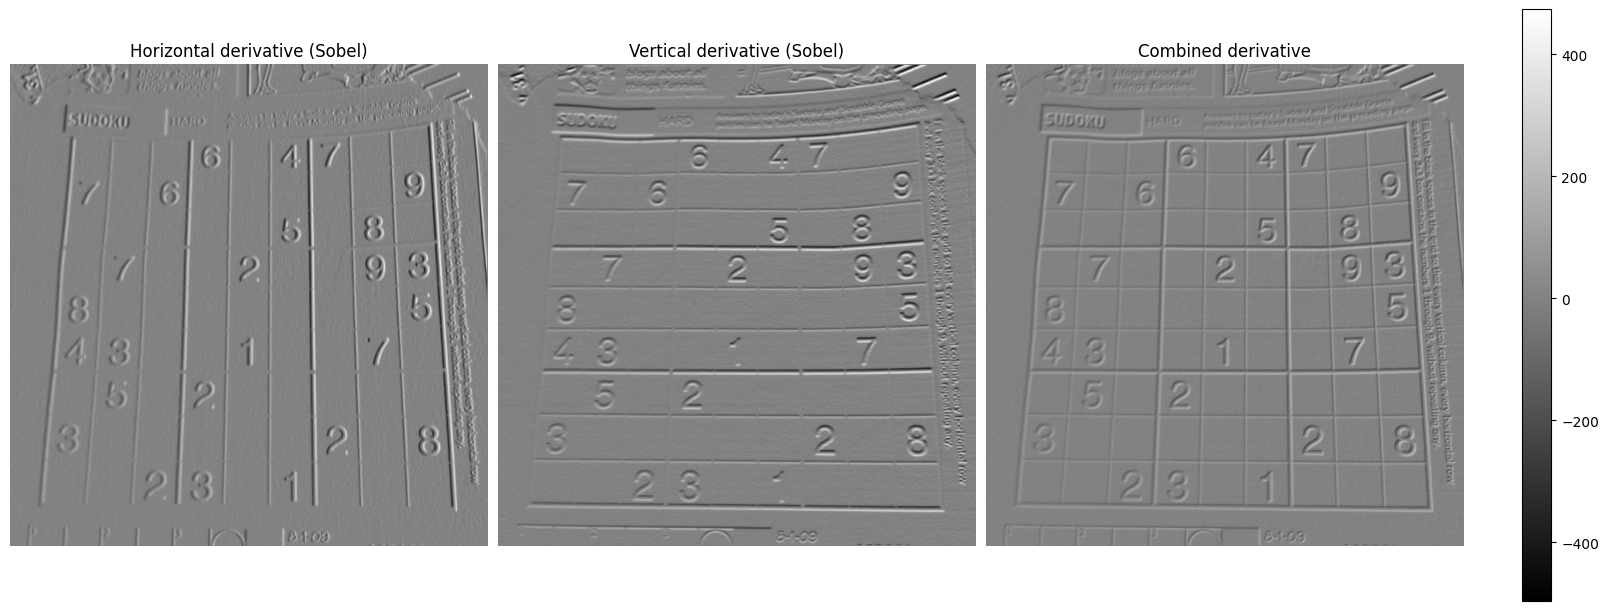

In [2]:
    # Sobel Operator (Replace with Scharr operator if testing that method)
    # Theories proposed in Article:
    # 1. Image derivatives can be used to measure how quickly pixel intensity changes.
    #   a) The Sobel operator can be used, two 3x3 matrices (aka kernels), to approximate changes
    # 2. Better to use more than 1D bc it will include pixels from the neighboring rows & columns.
    # Note: cv2.CV_64F is used to keep negative derivatives (caused by transition from light --> dark pixels)
    #   a) Instead of clipping to 0 bc default 'uint8' units are from 0-255.

    # Horizontal Derivative (Change along X-axis) - WIP
    # Parameters: (src, depth, dx=1, dy=0) -> 1st order derivative in X, 0 in Y
    derivative_x = cv2.Sobel(sudoku_image, cv2.CV_64F, 1, 0)
    # Vertical Derivative (Change along Y-axis) - WIP
    # Parameters: (src, depth, dx=0, dy=1) -> 0 in X, 1st order derivative in Y
    derivative_y = cv2.Sobel(sudoku_image, cv2.CV_64F, 0, 1)

    # Scharr Operator
    #derivative_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)
    #derivative_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)

    # Combine the X and Y derivatives to see both horizontal and vertical edges
    derivative_combined = cv2.addWeighted(derivative_x, 0.5, derivative_y, 0.5, 0)

    # Calculate min/max for consistent visualization
    min_value = min(derivative_x.min(), derivative_y.min(), derivative_combined.min())
    max_value = max(derivative_x.max(), derivative_y.max(), derivative_combined.max())
    print(f"Value range: ({min_value:.2f}, {max_value:.2f})")

    # 4. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)

    # Horizontal Derivative
    axes[0].imshow(derivative_x, cmap='gray', vmin=min_value, vmax=max_value)
    axes[0].set_title("Horizontal derivative (Sobel)")
    axes[0].axis('off')

    # Vertical Derivative
    sudoku_image_1 = axes[1].imshow(derivative_y, cmap='gray', vmin=min_value, vmax=max_value)
    axes[1].set_title("Vertical derivative (Sobel)")
    axes[1].axis('off')

    # Combined
    sudoku_image_2 = axes[2].imshow(derivative_combined, cmap='gray', vmin=min_value, vmax=max_value)
    axes[2].set_title("Combined derivative")
    axes[2].axis('off')

    # Add colorbar
    color_bar = fig.colorbar(sudoku_image_2, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.025, pad=0.04)
    
    plt.show()

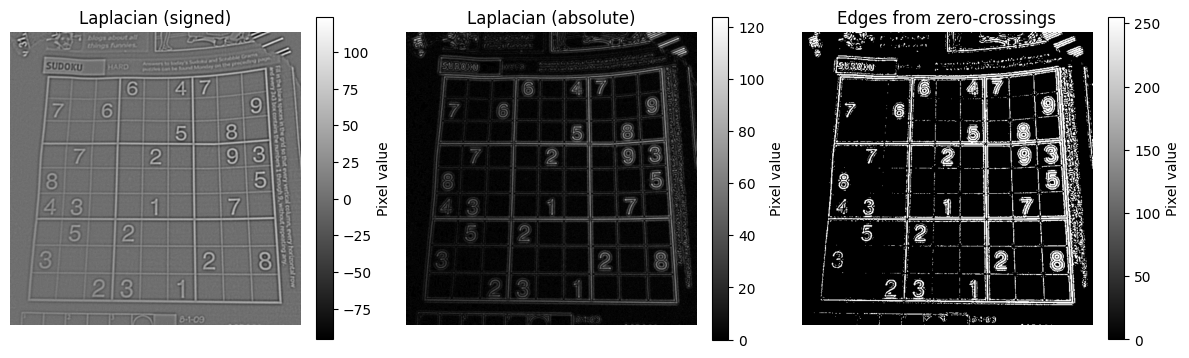

In [3]:
# Before:
# Sobel Operator: 1st Order Derivative - Single Directional 
# Now:
# Laplacian Operator : 2nd Order Derivative - Bidirectional - Scalar
#    a) Issue: Extremely sensitive to noise, Amplifies.
# Begin by smoothing out the image by combining Gaussian + Laplacian
#    a) aka Laplacian of Gaussian (LoG)
# Use cv2.CV_16S (16-bit signed interger) due to negative clipping
#    a) 2nd Order Derivatives contain negative and positive curvatures

sudoku_image = cv2.GaussianBlur(sudoku_image, (7, 7), 0)
laplacian_signed = cv2.Laplacian(sudoku_image, cv2.CV_16S, ksize=3)

# Absolute Value Visualization
laplacian_absolute = cv2.convertScaleAbs(laplacian_signed)

laplacian_sign = np.sign(laplacian_signed)

# Stores 'zero_crossings' variable: whether a pixel at position (x, y) is a zero-crossing candidate.
#    a) In their example, a pixel is zero-crossing if its sign (+ or -) differs from the sign of any
#       shifted pixel by five positions in either horizontal or vertical direction.
zero_crossings = np.zeros_like(laplacian_sign, dtype=bool)

# Check pixels 5 steps away: If the product of pixel [x] = +1 & pixel[x+5] = -1, their product is negative.
#    a) When this occurs, we know a 'zero_crossings' is present somewhere b/w the two checked pixels.
# Nifty vectorization trick (np.roll) to shift image by one pixel vs:
#  if sign[x, y] != sign[x+1, y]: found_edge = True

for shift in [-5, 5]:
    zero_crossings |= (np.roll(laplacian_sign, shift, axis=0) * laplacian_sign < 0)
    zero_crossings |= (np.roll(laplacian_sign, shift, axis=1) * laplacian_sign < 0)

# 'zero_crossings' occur even in flat gradient regions due to noise fluctuations around 0.
# We can filter these out by adding a minimum Laplacian magnitude.

threshold = 20
edges = np.uint8(zero_crossings & (np.abs(laplacian_signed) > threshold)) * 255

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
im1 = plt.imshow(laplacian_signed, cmap='gray', vmin=laplacian_signed.min(), vmax=laplacian_signed.max())
plt.title("Laplacian (signed)")
plt.axis('off')
plt.colorbar(im1, fraction=0.05, pad=0.05, label='Pixel value')

plt.subplot(1, 3, 2)
im2 = plt.imshow(laplacian_absolute, cmap='gray', vmin=laplacian_absolute.min(), vmax=laplacian_absolute.max())
plt.title("Laplacian (absolute)")
plt.axis('off')
plt.colorbar(im2, fraction=0.05, pad=0.05, label='Pixel value')

plt.subplot(1, 3, 3)
im2 = plt.imshow(edges, cmap='gray', vmin=edges.min(), vmax=edges.max())
plt.title("Edges from zero-crossings")
plt.axis('off')
plt.colorbar(im2, fraction=0.05, pad=0.05, label='Pixel value')

plt.tight_layout()
plt.show()